# Air Pollution Forecasting

Dataset: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data
    
This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.
The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

No: row number

year: year of data in this row

month: month of data in this row

day: day of data in this row

hour: hour of data in this row

pm2.5: PM2.5 concentration

DEWP: Dew Point

TEMP: Temperature

PRES: Pressure

cbwd: Combined wind direction

Iws: Cumulated wind speed

Is: Cumulated hours of snow

Ir: Cumulated hours of rain

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

#  LSTM
Long Short Term Memory networks

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.
As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.
Instead of neurons, LSTM networks have memory blocks that are connected through layers.A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

Forget Gate: conditionally decides what information to throw away from the block.

Input Gate: conditionally decides which values from the input to update the memory state.

Output Gate: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

We can see how we may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

1. Data cleaning
2. Use heatmap to see corelation between variables
3. plot each column
4. All features are normalized, then the dataset is transformed into a supervised learning problem
5. Design network

In [39]:
from IPython.display import display, Markdown
from math import sqrt
import tensorflow as tf
from numpy import concatenate
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize']=10,8
#from keras.layers import LSTM



In [40]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset1 = read_csv('timeseries_train.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset2 = read_csv('timeseries_test.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset=pd.concat([dataset1,dataset2]) 

In [41]:
dataset.isnull().sum()

pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [42]:
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [43]:
dataset.isnull().sum()

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [44]:
def report(df):
    display(Markdown('<b>head():</b>'))
    display(df.head())
    display(Markdown('<b>describe():</b>'))
    display(df.describe())
    display(Markdown('<b>info():</b>'))
    display(df.info(verbose=True))
    display(Markdown('<b>infer_dtype():</b>'))
    display(df.apply(lambda x: pd.api.types.infer_dtype(x.values)))

In [45]:
report(dataset)

<b>head():</b>

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


<b>describe():</b>

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


<b>info():</b>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
pollution    43800 non-null float64
dew          43800 non-null int64
temp         43800 non-null float64
press        43800 non-null float64
wnd_dir      43800 non-null object
wnd_spd      43800 non-null float64
snow         43800 non-null int64
rain         43800 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


None

<b>infer_dtype():</b>

pollution    floating
dew           integer
temp         floating
press        floating
wnd_dir        string
wnd_spd      floating
snow          integer
rain          integer
dtype: object

In [46]:
dataset.shape

(43800, 8)

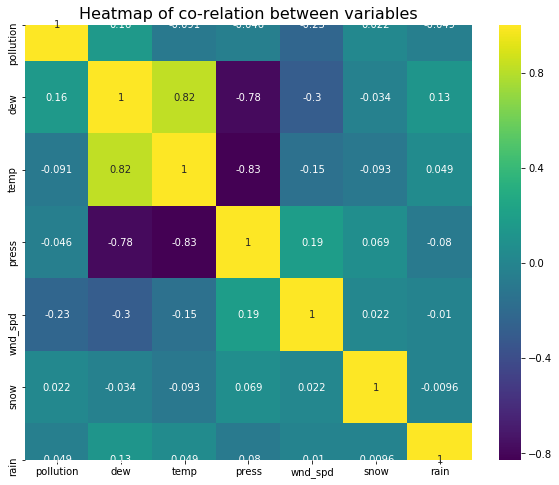

In [47]:
#Use heatmap to see corelation between variables
sns.heatmap(dataset.corr(),annot=True,cmap='viridis')
plt.title('Heatmap of co-relation between variables',fontsize=16)
plt.show()

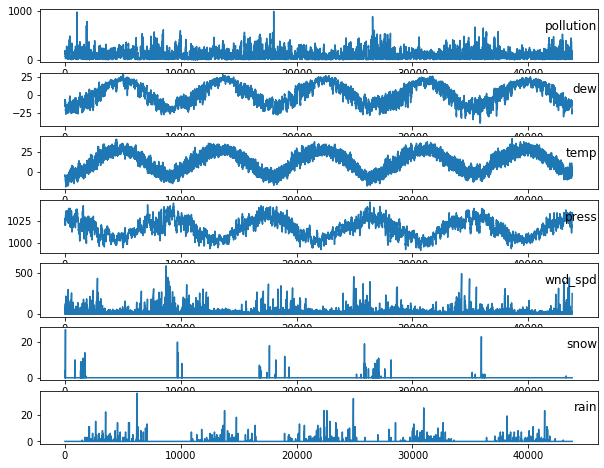

In [48]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
# Avoiding coloumn 4 wnd_dir as it is string
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

# All features are normalized, then the dataset is transformed into a supervised learning problem

In [49]:
# convert series to supervised learning
"""
Frame a time series as a supervised learning dataset.
Arguments:
data: Sequence of observations as a list or NumPy array.
n_in: Number of lag observations as input (X).
n_out: Number of observations as output (y).
dropnan: Boolean whether or not to drop rows with NaN values.
Returns:
Pandas DataFrame of series framed for supervised learning.
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


We will use 3 hours of data as input

In [50]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_hours = 3
n_features = 8

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0


In [51]:
print(reframed.shape)

(43797, 32)


 The inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features]

We have 3 * 8 + 8 columns in our framed dataset. We will take 3 * 8 or 24 columns as input for the obs of all features across the previous 3 hours. We will take just the pollution variable as output at the following hour

In [52]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


# Design network

Fit an LSTM on the multivariate input data


We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution.

In [53]:
import warnings;
warnings.filterwarnings('ignore');

# design network

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)
# To save model
model.save('LSTM_model.hdf5')
# Training Phase
model.summary()

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 2s - loss: 0.0476 - val_loss: 0.0794
Epoch 2/50
 - 1s - loss: 0.0267 - val_loss: 0.0461
Epoch 3/50
 - 1s - loss: 0.0218 - val_loss: 0.0300
Epoch 4/50
 - 1s - loss: 0.0209 - val_loss: 0.0231
Epoch 5/50
 - 1s - loss: 0.0202 - val_loss: 0.0201
Epoch 6/50
 - 1s - loss: 0.0198 - val_loss: 0.0186
Epoch 7/50
 - 2s - loss: 0.0191 - val_loss: 0.0175
Epoch 8/50
 - 1s - loss: 0.0188 - val_loss: 0.0172
Epoch 9/50
 - 1s - loss: 0.0184 - val_loss: 0.0170
Epoch 10/50
 - 1s - loss: 0.0180 - val_loss: 0.0164
Epoch 11/50
 - 1s - loss: 0.0176 - val_loss: 0.0160
Epoch 12/50
 - 1s - loss: 0.0171 - val_loss: 0.0157
Epoch 13/50
 - 1s - loss: 0.0167 - val_loss: 0.0153
Epoch 14/50
 - 1s - loss: 0.0163 - val_loss: 0.0153
Epoch 15/50
 - 1s - loss: 0.0161 - val_loss: 0.0151
Epoch 16/50
 - 2s - loss: 0.0157 - val_loss: 0.0148
Epoch 17/50
 - 1s - loss: 0.0155 - val_loss: 0.0150
Epoch 18/50
 - 1s - loss: 0.0153 - val_loss: 0.0148
Epoch 19/50
 - 1s - loss

# plot history
A plot of train and test loss over the epochs is plotted

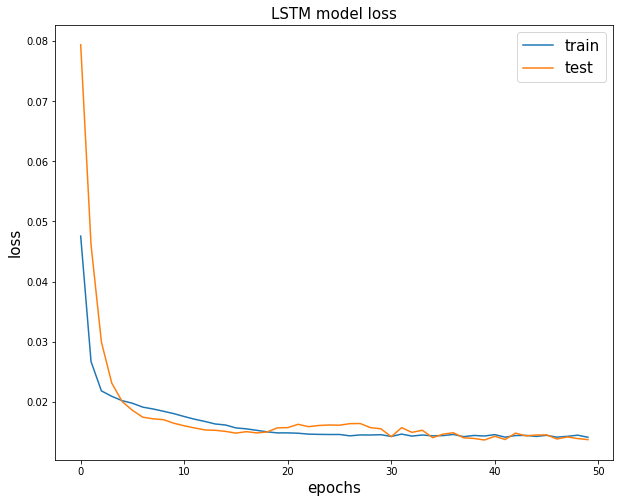

In [54]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

pyplot.title('LSTM model loss',size=15)
pyplot.ylabel('loss',size=15)
pyplot.xlabel('epochs',size=15)
pyplot.legend(loc='upper right',fontsize=15)

pyplot.show()

In [55]:
# make a prediction
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

The gist of the change is that we concatenate the y or yhat column with the last 7 features of the test dataset in order to inverse the scaling

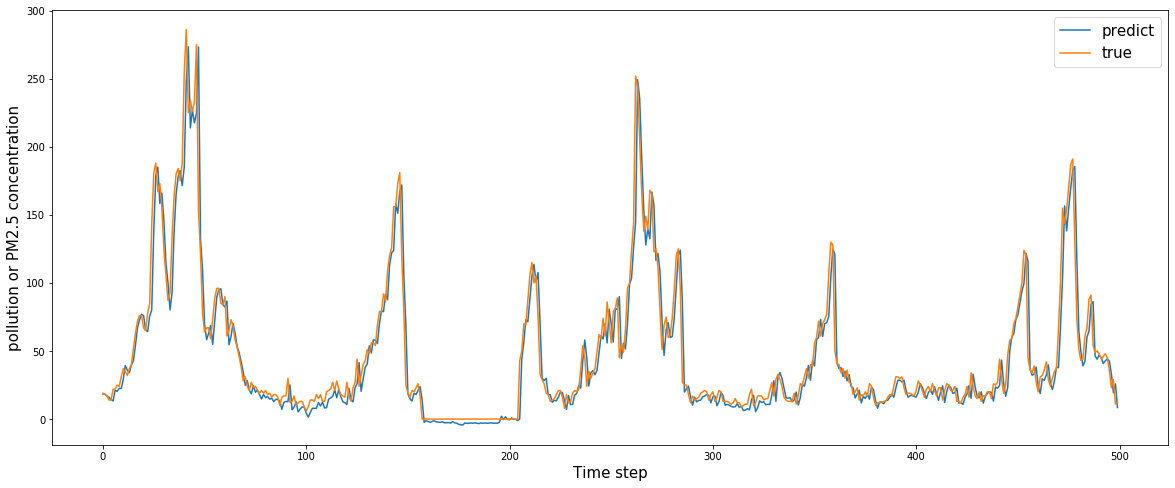

In [56]:
''' Plotting the first 500 entries to see prediction '''
pyplot.figure(figsize=(20,8))
pyplot.plot(inv_yhat[:500], label='predict')
pyplot.plot(inv_y[:500], label='true')
pyplot.legend()

pyplot.ylabel('pollution or PM2.5 concentration', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

pyplot.show()

In [57]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE FOR LSTM:: %.3f' % rmse)

Test RMSE FOR LSTM:: 26.303


# Fit an GRU on the multivariate input data

We will use 3 hours of data as input

In [58]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_hours = 3
n_features = 8

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0


In [59]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


# Design network
Fit an GRU on the multivariate input data

In [60]:

model_gru = Sequential()
model_gru.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(Dense(1))
model_gru.compile(loss='mae', optimizer='adam')

history_gru=model_gru.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# To save model
model_gru.save('GRU_model.hdf5')
# Training Phase
model_gru.summary()

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 2s - loss: 0.0379 - val_loss: 0.0334
Epoch 2/50
 - 1s - loss: 0.0207 - val_loss: 0.0175
Epoch 3/50
 - 1s - loss: 0.0188 - val_loss: 0.0162
Epoch 4/50
 - 1s - loss: 0.0177 - val_loss: 0.0159
Epoch 5/50
 - 1s - loss: 0.0170 - val_loss: 0.0175
Epoch 6/50
 - 1s - loss: 0.0179 - val_loss: 0.0166
Epoch 7/50
 - 1s - loss: 0.0165 - val_loss: 0.0171
Epoch 8/50
 - 1s - loss: 0.0165 - val_loss: 0.0152
Epoch 9/50
 - 1s - loss: 0.0165 - val_loss: 0.0144
Epoch 10/50
 - 1s - loss: 0.0161 - val_loss: 0.0148
Epoch 11/50
 - 1s - loss: 0.0151 - val_loss: 0.0152
Epoch 12/50
 - 1s - loss: 0.0160 - val_loss: 0.0155
Epoch 13/50
 - 1s - loss: 0.0152 - val_loss: 0.0134
Epoch 14/50
 - 1s - loss: 0.0144 - val_loss: 0.0148
Epoch 15/50
 - 1s - loss: 0.0151 - val_loss: 0.0150
Epoch 16/50
 - 1s - loss: 0.0149 - val_loss: 0.0133
Epoch 17/50
 - 1s - loss: 0.0145 - val_loss: 0.0144
Epoch 18/50
 - 1s - loss: 0.0147 - val_loss: 0.0137
Epoch 19/50
 - 1s - loss

# plot history
A plot of train and test loss over the epochs is plotted

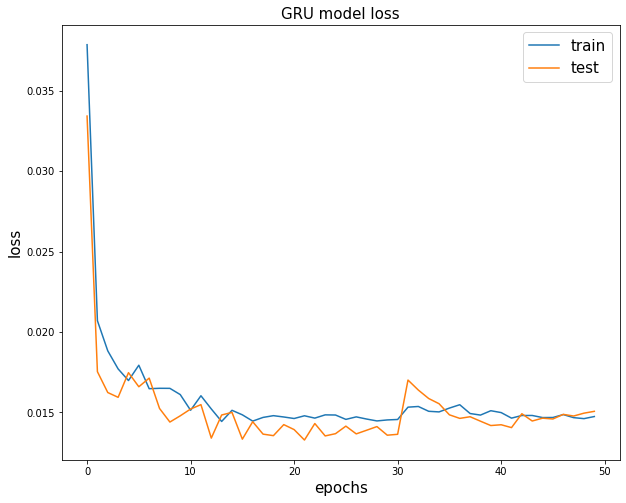

In [61]:
# plot history
pyplot.plot(history_gru.history['loss'], label='train')
pyplot.plot(history_gru.history['val_loss'], label='test')

pyplot.title('GRU model loss',size=15)
pyplot.ylabel('loss',size=15)
pyplot.xlabel('epochs',size=15)
pyplot.legend(loc='upper right',fontsize=15)

pyplot.show()

In [62]:

# make a prediction
yhat_gru = model_gru.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat_gru = concatenate((yhat_gru, test_X[:, -7:]), axis=1)
inv_yhat_gru = scaler.inverse_transform(inv_yhat_gru)
inv_yhat_gru = inv_yhat_gru[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


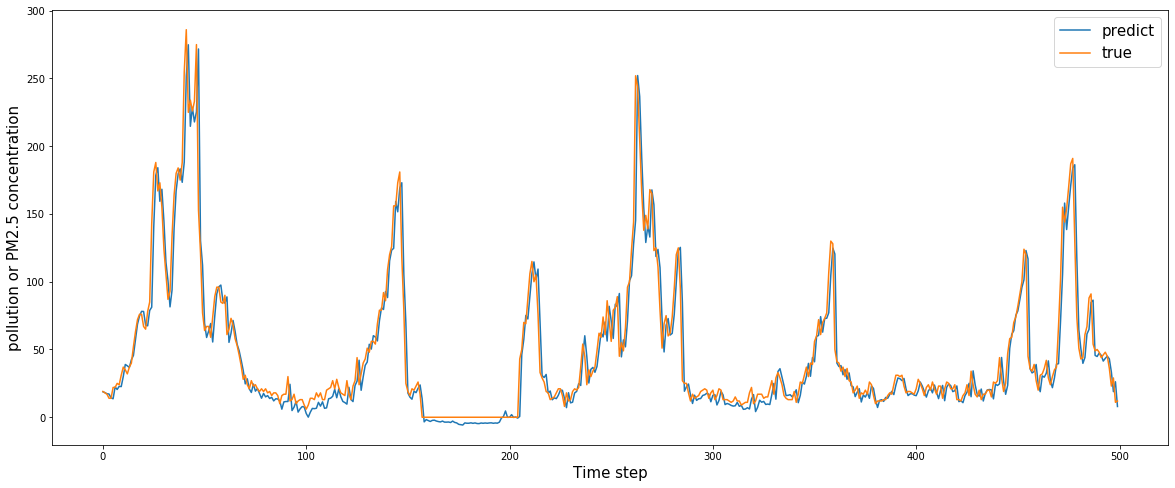

In [63]:
''' Plotting the first 500 entries to see prediction '''
pyplot.figure(figsize=(20,8))
pyplot.plot(inv_yhat_gru[:500], label='predict')
pyplot.plot(inv_y[:500], label='true')
pyplot.legend()

pyplot.ylabel('pollution or PM2.5 concentration', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

pyplot.show()

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [64]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat_gru))
print('Test RMSE FOR GRU:: %.3f' % rmse)

Test RMSE FOR GRU:: 27.393


End of project